## MobileNetV2

In [ ]:
import imageio.v2 as imageio
from PIL import Image
from keras.applications.mobilenet_v2 import MobileNetV2
import numpy as np
import imageio.v2 as imageio  
from keras.applications.mobilenet_v2 import preprocess_input
from keras.applications.mobilenet_v2 import decode_predictions
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

In [2]:
import os
os.chdir("c:\\Users\\riandrea\\Desktop\\Github\\SceneDetect")
os.getcwd()


'c:\\Users\\riandrea\\Desktop\\Github\\SceneDetect'

In [ ]:
MobileNetV2 = MobileNetV2(weights='imagenet')
MobileNetV2

In [ ]:
# Bild laden
image_path = r"cats_and_dogs_small\test\dogs\1509.jpg"

# Bild auf die gewünschte Eingabegröße skalieren unsere Modell nimmt 180 x 180 x3
img = image.load_img(image_path, target_size=(224, 224))

# Bild anzeigen
plt.imshow(img)
plt.axis("off")
plt.show()


In [ ]:
img = imageio.imread(image_path)

# Bild auf die gewünschte Größe (224, 224) skalieren
img_resized = Image.fromarray(img).resize((224, 224))

# Bild in das numpy Array einfügen
data = np.empty((1, 224, 224, 3))
data[0] = np.array(img_resized)

In [ ]:
data = preprocess_input(data)
data.shape

In [ ]:
predictions = MobileNetV2.predict(data)
print('Shape: {}'.format(predictions.shape))

In [ ]:
output_neuron = np.argmax(predictions[0])
print('Most active neuron: {} ({:.2f}%)'.format(
    output_neuron,
    100 * predictions[0][output_neuron]
))


In [ ]:
for name, desc, score in decode_predictions(predictions)[0]:
    print('- {} ({:.2f}%%)'.format(desc, 100 * score))

---
## Fine tune MobileNetV2

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow import keras

In [4]:
MobileNetV2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [6]:
MobileNetV2.trainable = False

In [7]:
MobileNetV2_finetuned = models.Sequential([
    MobileNetV2,
    layers.GlobalAveragePooling2D(),        # Globales Pooling der Features
    layers.Dense(1024, activation='relu'),  # Neue Dense-Schicht
    layers.Dense(1, activation='sigmoid')   # Ausgabe-Schicht für binäre Klassifikation
])

In [10]:
MobileNetV2_finetuned.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy', # binär
              metrics=['accuracy'])

In [11]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0,  # Normalisierung
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [13]:
train_dir = r'user_pictures\100_pic_train'            # Dein Trainingsdaten-Verzeichnis
validation_dir = r'user_pictures/100_pic_valid'  # Dein Validierungsdaten-Verzeichnis

#Achtung die Klassen werden aus dem Verzeichnis erstellt wir haben in dem Ornder "100_pic" zwei Weitere Ordner namens Cat und Dogs 
# woraus sich die Klassen herausstellen haben wir weitere Ordner wie Pferd und Wolf haben wir 4 Klassen
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')

Found 202 images belonging to 2 classes.
Found 202 images belonging to 2 classes.


In [ ]:
import json
import os

# Überprüfen, ob das Modell bereits existiert umso Ressourcen zupassen falls ein Modell bereits hinterlegt wurde
path_to_model = r"model/fine_tuned_model.keras"

if os.path.isfile(path_to_model):
    history = load_model(path_to_model)
    print("exist")

else:       
    # Falls kein Modell da ist wird das Modell trainiert und nur das Beste modell gespeichert.
    # Trainiere das Modell
    history = MobileNetV2_finetuned.fit(
        train_generator,
        epochs=8,
        validation_data=validation_generator,
        callbacks=[  
            keras.callbacks.ModelCheckpoint('model/fine_tuned_model.keras', save_best_only=True, monitor='val_loss')
        ]
    )
    
    # Die Parameter in History werden zwischen gespeichert in einer JSON da sonst später die History nicht ausgeben werden kann.

    history_dict = history.history  # Das History-Objekt enthält alle Metriken
    with open('train_history.json', 'w') as json_file:
        json.dump(history_dict, json_file, indent=4)


c:\Users\riandrea\Desktop\Github\SceneDetect\project\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.7152 - loss: 0.6663

c:\Users\riandrea\Desktop\Github\SceneDetect\project\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 624ms/step - accuracy: 0.7242 - loss: 0.6558 - val_accuracy: 0.9455 - val_loss: 0.2643
Epoch 2/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 484ms/step - accuracy: 0.9040 - loss: 0.3920 - val_accuracy: 0.9653 - val_loss: 0.0846
Epoch 3/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 725ms/step - accuracy: 0.9385 - loss: 0.1588 - val_accuracy: 0.9752 - val_loss: 0.0734
Epoch 4/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 734ms/step - accuracy: 0.9699 - loss: 0.1233 - val_accuracy: 0.9901 - val_loss: 0.0400
Epoch 5/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 683ms/step - accuracy: 0.9661 - loss: 0.0702 - val_accuracy: 0.9950 - val_loss: 0.0324
Epoch 6/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 639ms/step - accuracy: 0.9801 - loss: 0.0541 - val_accuracy: 0.9604 - val_loss: 0.0987
Epoch 7/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 741ms/step - accuracy: 0.9763 - loss: 0.0689 - val_accuracy: 0.9950 - val_loss: 0.0185
Epoch 8/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 729ms/step - accuracy: 0.9711 - loss: 0.0559 - val_accuracy: 1.0000 - val_loss: 0.0057


In [20]:
# Evaluierung des Modells auf den Validierungsdaten
eval_results = MobileNetV2_finetuned.evaluate(validation_generator)
print(f"Loss: {eval_results[0]}")
print(f"Accuracy: {eval_results[1]}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 1.0000 - loss: 0.0049
Loss: 0.005655291024595499
Accuracy: 1.0


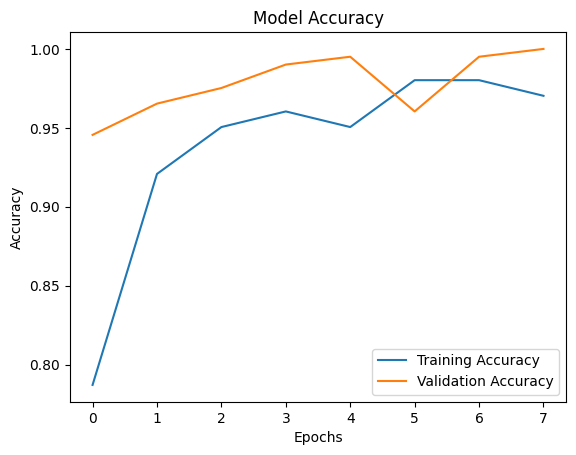

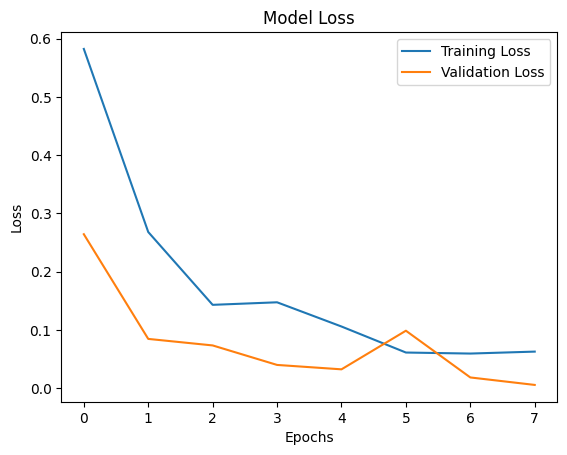

In [21]:
import json
import matplotlib.pyplot as plt

# Laden der JSON-Datei mit den Trainingsdaten
with open('train_history.json', 'r') as json_file:
    history_dict = json.load(json_file)

# Beispiel für das Plotten der Trainings- und Validierungsgenauigkeit
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Beispiel für das Plotten des Trainings- und Validierungsverlusts
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Predictions 

In [28]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# 1. Lade das Bild, das du testen möchtest
img_path = r'cats_and_dogs_small\train\dogs\155.jpg'  # Pfad zum Bild, das du testen möchtest

# Lade das Bild und skaliere es auf die Eingabegröße des Modells
img = image.load_img(img_path, target_size=(224, 224))

# 2. Konvertiere das Bild in ein Array und normalisiere es
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Füge eine Batch-Dimension hinzu
img_array /= 255.0  # Normalisiere das Bild (falls beim Training auch normalisiert wurde)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Das Bild zeigt die Hund Klasse.


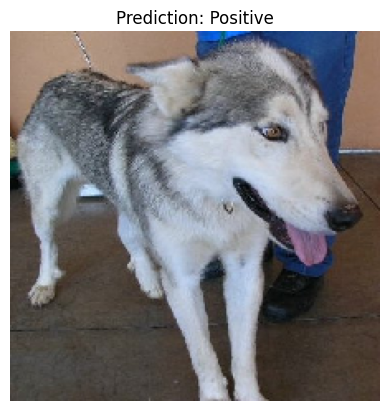

[[0.9953689]]


In [29]:

# 3. Vorhersage des Modells
predictions = MobileNetV2_finetuned.predict(img_array)

# 4. Interpretiere die Vorhersage
# Hier nehmen wir an, dass es sich um ein binäres Klassifikationsproblem handelt
# (z.B. Hund vs. Katze)

# Bei binärer Klassifikation gibt das Modell eine Wahrscheinlichkeit zurück
# Wenn die Wahrscheinlichkeit größer als 0.5 ist, dann gehört das Bild zur positiven Klasse
if predictions[0] > 0.5:
    print("Das Bild zeigt die Hund Klasse.")
else:
    print("Das Bild zeigt die Katzen Klasse.")

# 5. (Optional) Visualisiere das Bild
plt.imshow(img)
plt.title(f'Prediction: {"Positive" if predictions[0] > 0.5 else "Negative"}')
plt.axis('off')  # Verstecke die Achsen
#plt.text(x=0,y=0,s=str(predictions))
plt.show()
print(predictions)